In [1]:
import os
import pickle
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionResNetV2
from transformers import BertTokenizer, TFBertModel
from official.nlp import optimization
import matplotlib.pyplot as plt

d:\Conda\envs\GPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Conda\envs\GPU\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\Conda\envs\GPU\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not

In [2]:
# Class for loading image and text data


class ITM_DataLoader:
    BATCH_SIZE = 16
    IMAGE_SIZE = (224, 224)
    IMAGE_SHAPE = (224, 224, 3)
    MAX_SENTENCE_LENGTH = 50
    SENTENCE_EMBEDDING_SHAPE = 384
    AUTOTUNE = tf.data.AUTOTUNE
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DATA_PATH = "D:/_GITHUB_/Image-Text-Matching/data"
    IMAGES_PATH = DATA_PATH + "/images"
    train_data_file = DATA_PATH + "/flickr8k.TrainImages.txt"
    dev_data_file = DATA_PATH + "/flickr8k.DevImages.txt"
    test_data_file = DATA_PATH + "/flickr8k.TestImages.txt"
    train_ds = None
    val_ds = None
    test_ds = None

    def __init__(self):
        self.train_ds = self.load_classifier_data(self.train_data_file)
        self.val_ds = self.load_classifier_data(self.dev_data_file)
        self.test_ds = self.load_classifier_data(self.test_data_file)
        print("done loading data...")

    def process_input(
        self, img_path, text_input_ids, text_attention_mask, label, caption
    ):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32) / 255.0
        file_name = tf.strings.split(img_path, os.path.sep)[-1]
        features = {
            "image_input": img,
            "text_input_ids": text_input_ids,
            "text_attention_mask": text_attention_mask,
            "caption": caption,
            "file_name": file_name,
        }
        return features, label

    def load_classifier_data(self, data_files):
        print("LOADING data from " + str(data_files))
        image_data = []
        text_input_ids = []
        text_attention_masks = []
        label_data = []
        captions = []

        with open(data_files) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip("\n")
                img_name, text, raw_label = line.split("\t")
                img_name = os.path.join(self.IMAGES_PATH, img_name.strip())
                label = [1, 0] if raw_label == "match" else [0, 1]

                encoding = self.tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=self.SENTENCE_EMBEDDING_SHAPE,  # Ensure this attribute is defined
                    padding="max_length",
                    truncation=True,
                    return_tensors="tf",
                )

                image_data.append(img_name)
                text_input_ids.append(
                    encoding["input_ids"][0]
                )  # [0] to unpack from batch
                text_attention_masks.append(
                    encoding["attention_mask"][0]
                )  # [0] to unpack from batch
                label_data.append(label)
                captions.append(text)

        dataset = tf.data.Dataset.from_tensor_slices(
            (image_data, text_input_ids, text_attention_masks, label_data, captions)
        )
        dataset = dataset.map(self.process_input, num_parallel_calls=self.AUTOTUNE)
        dataset = (
            dataset.shuffle(self.BATCH_SIZE * 8)
            .batch(self.BATCH_SIZE)
            .prefetch(self.AUTOTUNE)
        )
        return dataset

    def print_data_samples(self, dataset):
        print("PRINTING data samples...")
        print("-----------------------------------------")
        for features_batch, label_batch in dataset.take(1):
            for i in range(1):
                print(f'Image pixels: {features_batch["image_input"]}')
                print(f'Caption: {features_batch["caption"].numpy()}')
                label = label_batch.numpy()[i]
                print(f"Label : {label}")
        print("-----------------------------------------")

In [3]:
# Main class for the Image-Text Matching (ITM) task


class ITM_Classifier(ITM_DataLoader):
    epochs = 1
    learning_rate = 4e-5
    class_names = {"match", "no-match"}
    num_classes = len(class_names)
    classifier_model = None
    history = None
    classifier_model_name = "ITM_InceptionV3_BERT"

    def __init__(self):
        super().__init__()
        self.build_classifier_model()
        self.train_classifier_model()
        self.test_classifier_model()

    # return learnt feature representations of input data (images)
    def create_vision_encoder(
        self, num_projection_layers, projection_dims, dropout_rate
    ):
        img_input = layers.Input(shape=self.IMAGE_SHAPE, name="image_input")

        # Use InceptionResNetV2 with ImageNet weights, excluding the top (fully connected) layer
        base_model = InceptionResNetV2(
            include_top=False,
            weights="imagenet",
            input_tensor=img_input,
            input_shape=self.IMAGE_SHAPE,
        )
        base_model.trainable = False

        cnn_layer = base_model.output
        cnn_layer = layers.GlobalAveragePooling2D()(cnn_layer)
        cnn_layer = layers.Dropout(dropout_rate)(cnn_layer)

        outputs = self.project_embeddings(
            cnn_layer, num_projection_layers, projection_dims, dropout_rate
        )
        return img_input, outputs

    # return learnt feature representations based on dense layers, dropout, and layer normalisation
    def project_embeddings(
        self, embeddings, num_projection_layers, projection_dims, dropout_rate
    ):
        projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
        for _ in range(num_projection_layers):
            x = tf.nn.gelu(projected_embeddings)
            x = layers.Dense(projection_dims)(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Add()([projected_embeddings, x])
            projected_embeddings = layers.LayerNormalization()(x)
        return projected_embeddings

    # return learnt feature representations of input data (text embeddings in the form of dense vectors)
    def create_text_encoder(
        self, num_projection_layers=1, projection_dims=128, dropout_rate=0.1
    ):
        bert_model = TFBertModel.from_pretrained("bert-base-uncased")
        bert_model.trainable = (
            False  # Set to False to freeze BERT weights, or True to fine-tune
        )

        # Define the inputs for the BERT model
        text_input_ids = tf.keras.Input(
            shape=(self.SENTENCE_EMBEDDING_SHAPE,),
            dtype=tf.int32,
            name="text_input_ids",
        )
        text_attention_mask = tf.keras.Input(
            shape=(self.SENTENCE_EMBEDDING_SHAPE,),
            dtype=tf.int32,
            name="text_attention_mask",
        )

        # Getting the output from BERT
        bert_output = bert_model(text_input_ids, attention_mask=text_attention_mask)
        text_features = bert_output.last_hidden_state
        text_features = tf.keras.layers.GlobalAveragePooling1D()(text_features)

        # Project the BERT outputs to the desired dimensionality
        projected_embeddings = tf.keras.layers.Dense(
            projection_dims, activation="relu"
        )(text_features)
        for _ in range(
            1, num_projection_layers
        ):  # start from 1 because we already added one Dense layer
            x = tf.keras.layers.Dense(projection_dims, activation="relu")(
                projected_embeddings
            )
            x = tf.keras.layers.Dropout(dropout_rate)(x)
            projected_embeddings = tf.keras.layers.Add()(
                [projected_embeddings, x]
            )  # Element-wise addition
            projected_embeddings = tf.keras.layers.LayerNormalization()(
                projected_embeddings
            )

        return text_input_ids, text_attention_mask, projected_embeddings

    # put together the feature representations above to create the image-text (multimodal) deep learning model
    def build_classifier_model(self):
        print("BUILDING model")
        # Create the vision model part
        img_input, vision_net = self.create_vision_encoder(
            num_projection_layers=1, projection_dims=128, dropout_rate=0.1
        )

        # Create the text model part
        text_input_ids, text_attention_mask, text_net = self.create_text_encoder(
            num_projection_layers=1, projection_dims=128, dropout_rate=0.1
        )

        # Combine the outputs from both text and vision parts
        combined_features = tf.keras.layers.Concatenate(axis=1)([vision_net, text_net])
        combined_features = tf.keras.layers.Dense(512, activation="relu")(
            combined_features
        )
        combined_features = tf.keras.layers.Dropout(0.1)(combined_features)
        combined_features = tf.keras.layers.Dense(512, activation="relu")(
            combined_features
        )
        combined_features = tf.keras.layers.LayerNormalization()(combined_features)

        # Classifier layer
        final_output = tf.keras.layers.Dense(
            self.num_classes, activation="softmax", name=self.classifier_model_name
        )(combined_features)

        # Create the full model
        self.classifier_model = tf.keras.Model(
            inputs=[img_input, text_input_ids, text_attention_mask],
            outputs=final_output,
        )
        self.classifier_model.summary()

    def save_model(self):
        model_dir = "models"
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)  # Ensure directory exists
        model_path = os.path.join(model_dir, self.classifier_model_name)
        history_path = os.path.join(
            model_dir, f"{self.classifier_model_name}_history.pkl"
        )
        print("SAVING model to", model_path)
        self.classifier_model.save(model_path)  # Save the model
        with open(history_path, "wb") as f:
            pickle.dump(self.history.history, f)  # Save the training history

    def train_classifier_model(self):
        print(f"TRAINING model")
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        num_warmup_steps = int(0.2 * num_train_steps)

        loss = tf.keras.losses.KLDivergence()
        metrics = tf.keras.metrics.BinaryAccuracy()
        optimizer = optimization.create_optimizer(
            init_lr=self.learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            optimizer_type="adamw",
        )

        self.classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        # uncomment the next line if you wish to make use of early stopping during training
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=11, restore_best_weights=True)
        ]

        self.history = self.classifier_model.fit(
            x=self.train_ds,
            validation_data=self.val_ds,
            epochs=self.epochs,
            callbacks=callbacks,
        )
        self.save_model()

        print("model trained!")

    def test_classifier_model(self):
        print(
            "TESTING classifier model (showing a sample of image-text-matching predictions)..."
        )
        num_classifications = 0
        num_correct_predictions = 0

        # read test data for ITM classification
        for features, groundtruth in self.test_ds:
            groundtruth = groundtruth.numpy()
            predictions = self.classifier_model(features)
            predictions = predictions.numpy()
            captions = features["caption"].numpy()
            file_names = features["file_name"].numpy()

            # read test data per batch
            for batch_index in range(0, len(groundtruth)):
                predicted_values = predictions[batch_index]
                probability_match = predicted_values[0]
                probability_nomatch = predicted_values[1]
                predicted_class = (
                    "[1 0]" if probability_match > probability_nomatch else "[0 1]"
                )
                if str(groundtruth[batch_index]) == predicted_class:
                    num_correct_predictions += 1
                num_classifications += 1

                # print a sample of predictions -- about 10% of all possible
                if random.random() < 0.1:
                    caption = captions[batch_index]
                    file_name = file_names[batch_index].decode("utf-8")
                    print(
                        "ITM=%s PREDICTIONS: match=%s, no-match=%s \t -> \t %s"
                        % (caption, probability_match, probability_nomatch, file_name)
                    )

        # reveal test performance using our own calculations above
        accuracy = num_correct_predictions / num_classifications
        print("TEST accuracy=%4f" % (accuracy))

        # reveal test performance using Tensorflow calculations
        loss, accuracy = self.classifier_model.evaluate(self.test_ds)
        print(f"Tensorflow test method: Loss: {loss}; ACCURACY: {accuracy}")

In [4]:
def plot_training_history(itm):
    history_path = os.path.join('models', f'{itm.classifier_model_name}_history.pkl')
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    # Plot training & validation accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# Let's create an instance of the main class
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
itm = ITM_Classifier()

LOADING data from D:/_GITHUB_/Image-Text-Matching/data/flickr8k.TrainImages.txt
LOADING data from D:/_GITHUB_/Image-Text-Matching/data/flickr8k.DevImages.txt
LOADING data from D:/_GITHUB_/Image-Text-Matching/data/flickr8k.TestImages.txt
done loading data...
BUILDING model
219055592/219055592 [==============================] - 7s 0us/step


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

d:\Conda\envs\GPU\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['caption', 'file_name'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1212/1212 [==============================] - 982s 782ms/step - loss: 0.7128 - binary_accuracy: 0.5542 - val_loss: 0.6520 - val_binary_accuracy: 0.6375
SAVING model to models\ITM_InceptionV3_BERT


INFO:tensorflow:Assets written to: models\ITM_InceptionV3_BERT\assets


INFO:tensorflow:Assets written to: models\ITM_InceptionV3_BERT\assets


model trained!
TESTING classifier model (showing a sample of image-text-matching predictions)...


d:\Conda\envs\GPU\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['caption', 'file_name'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


ITM=b'Man bicycle up a road , while cows graze on a hill nearby .' PREDICTIONS: match=0.70566326, no-match=0.29433677 	 -> 	 110595925_f3395c8bd6.jpg
ITM=b'Skater rides skateboard down a long stair railing' PREDICTIONS: match=0.38013744, no-match=0.6198625 	 -> 	 1600208439_e94527b80f.jpg
ITM=b'Two young boys run across a green yard .' PREDICTIONS: match=0.47611627, no-match=0.5238837 	 -> 	 1659358141_0433c9bf99.jpg
ITM=b'Man playing with a brown dog on a dirt path .' PREDICTIONS: match=0.570576, no-match=0.429424 	 -> 	 1377668044_36398401dd.jpg
ITM=b'Dog with big collar running .' PREDICTIONS: match=0.74795175, no-match=0.25204828 	 -> 	 1552065993_b4dcd2eadf.jpg
ITM=b'Two dogs are playing with a stick in a lake .' PREDICTIONS: match=0.5907694, no-match=0.40923053 	 -> 	 1659358141_0433c9bf99.jpg
ITM=b'a tennis player in a green striped shirt is holding his hand up to his mouth .' PREDICTIONS: match=0.32888064, no-match=0.67111933 	 -> 	 1124448967_2221af8dc5.jpg
ITM=b'A group of wo

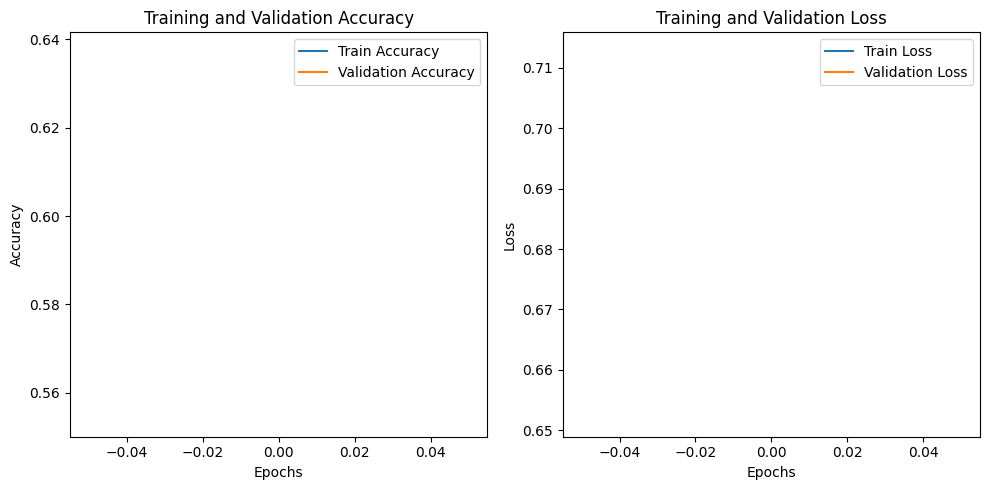

In [7]:
plot_training_history(itm)